In [44]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

Parámetros del sistema

In [45]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 0.5 # Frecuencia natural x<0
m = 1 # masa del oscilador
N = 50 # Numero de fonones
X_0 = 6 # Condición inicial

Frecuencia natural del oscilador

In [46]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [47]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [48]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [49]:
x = np.linspace(-25,25,1500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 50/50 [00:06<00:00,  7.64it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


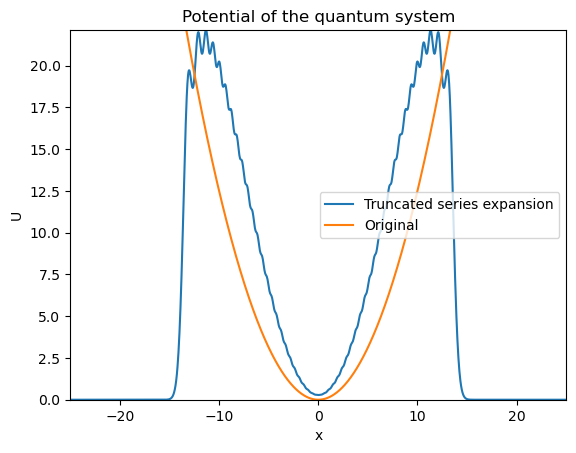

In [50]:
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [51]:
dt = 0.2 # Paso de tiempo
tf = 50 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [52]:
def check_state(psi):
    check = np.sum(np.diagonal(ket2dm(psi).full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [53]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [54]:
H = w_0*momentum(N)**2/2+U_q
options = Options(store_states=True,nsteps=50000)
result = mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)
# result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

Wigner function evolution

In [55]:
Wigner = []
wig_xvec = np.linspace(-12,12,100)
wig_pvec = np.linspace(-12,12,100)
for i in tqdm(range(np.size(tvec))):   
    Wigner.append(wigner(result.states[i], wig_xvec, wig_pvec))

100%|██████████| 251/251 [00:36<00:00,  6.84it/s]


Amount of negativity

In [56]:
neg = []
#pos = []

for i in range(np.shape(Wigner)[0]):
    neg.append(100*np.sum(((Wigner[i]<0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))
    #pos.append(100*np.sum(((Wigner[i]>=0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))

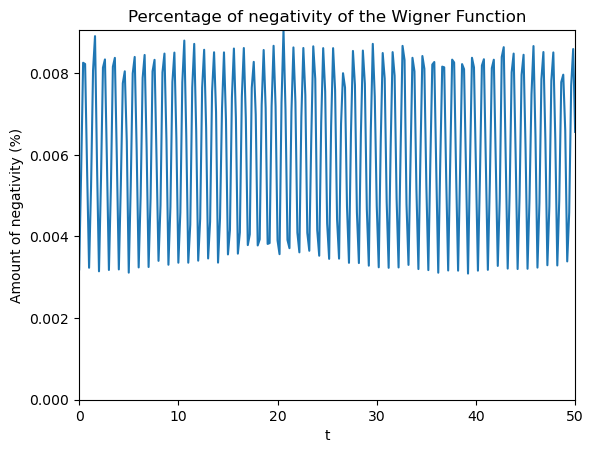

In [57]:
fig1 = plt.figure()
plt.plot(tvec,neg)
plt.xlim([0,tf])
plt.ylim([0,np.max(neg)])
plt.title('Percentage of negativity of the Wigner Function')
plt.xlabel('t')
plt.ylabel('Amount of negativity (%)')
plt.show()

Probability density

In [58]:
prob = []

for i in tqdm(range(np.size(tvec))):
    psi_x = 0
    for j in range(N):
        psi_x = psi_x + autoest(j,x,False)*result.states[i][j]
    prob.append(np.abs(psi_x)**2)

100%|██████████| 251/251 [00:06<00:00, 36.08it/s]


Save animations and figures

In [59]:
def update_Wigner(num,Wigner):
    plt.cla()
    wmap = wigner_cmap(Wigner[num])
    nrm = mpl.colors.Normalize(-Wigner[num].max(), Wigner[num].max())
    plt.contourf(wig_xvec, wig_pvec, Wigner[num], 100, cmap=cm.RdBu, norm=nrm)
    plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
    plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
    plt.title('Evolution of the Wigner function (t = '+str(format(tvec[num],'.3f'))+' s)')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('p')

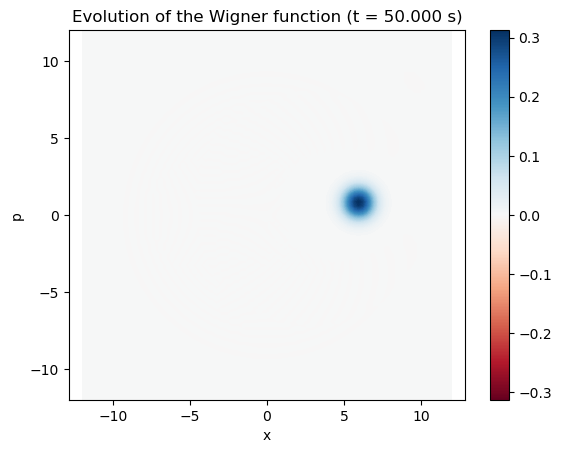

In [60]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(wig_xvec, wig_pvec, Wigner[0], 100, cmap=cm.RdBu, norm=nrm)
plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
animW = animation.FuncAnimation(imW, update_Wigner, range(np.size(tvec)), fargs = (Wigner, ), interval = 100)
animW.save('WIGNER.gif')
animW.save('WIGNER.mp4')

In [61]:
def update_prob(num,prob):
    ax1.cla()
    ax2.cla()
    ax1.plot(x, prob[num][0], label = '$|Ψ(x)|^2$', color = 'purple')
    ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
    ax1.set_xlim([np.min(x),np.max(x)])
    ax1.set_ylim([0,1.5])
    ax2.set_ylim([0,100])
    ax1.set_title('Evolution of probability density (t = '+str(format(tvec[num],'.3f'))+' s)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$|Ψ(x)|^2$')
    ax2.set_ylabel('U(x)')
    ax2.legend()

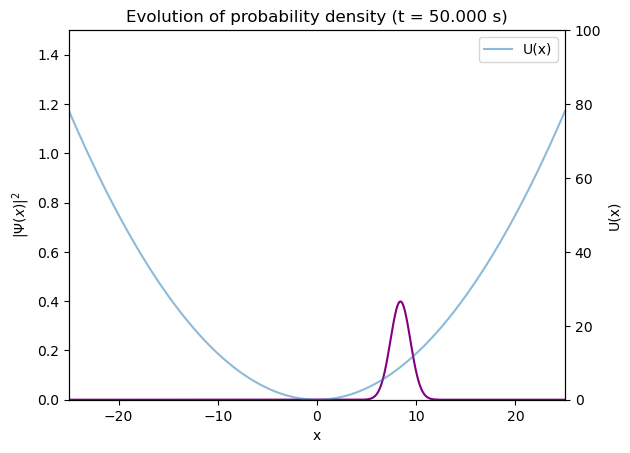

In [62]:
imP = plt.figure()
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(x, prob[0][0], label = '$|Ψ(x)|^2$', color = 'purple')
ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
animP = animation.FuncAnimation(imP, update_prob, range(np.size(tvec)), fargs = (prob, ), interval = 25)
animP.save('prob.gif')
animP.save('prob.mp4')

In [63]:
fig1.savefig('Negativity.png')